In [1]:
import numpy as np
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, ll_to_xy)
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import xarray as xr
import gc, glob
import pickle
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(1, '../../')
from util.ml import (preproc)
from util.wrf_process import (read_and_write)
import read_config

# Read processed files

In [3]:
Upol,Vpol = [],[]
for memb in [1,2,3,4,5,6,7,8,9,10]:
    if memb<10:
        Upol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutpol_U.pkl'))[0]))
        Vpol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutpol_V.pkl'))[0]))
    else:
        Upol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutpol_U.pkl'))[0]))
        Vpol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutpol_V.pkl'))[0]))        

In [4]:
rthratlw,rthratsw=[],[]
for memb in [1,2,3,4,5,6,7,8,9,10]:
    if memb<10:
        rthratlw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutcart_rthratlw.pkl'))[0])['pol'])
        rthratsw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutcart_rthratsw.pkl'))[0])['pol'])
    else:
        rthratlw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutcart_rthratlw.pkl'))[0])['pol'])
        rthratsw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutcart_rthratsw.pkl'))[0])['pol'])        

In [5]:
rthratlw_flat,rthratsw_flat = [],[]
for memb in range(len(rthratlw)):
    rthratlw_flat.append([obj.reshape(-1) for obj in rthratlw[memb]][:-1])
    rthratsw_flat.append([obj.reshape(-1) for obj in rthratsw[memb]][:-1])
del rthratlw,rthratsw
gc.collect()

0

# Surface intensity

In [10]:
def get_intensification(U=None,V=None):
    swspd = np.sqrt(np.asarray(U['pol'])[:,0,...]**2+np.asarray(V['pol'])[:,0,...]**2)
    return np.max(np.mean(swspd,axis=2),axis=1)

In [16]:
wspds = [get_intensification(Upol[i],Vpol[i]) for i in range(len(Upol))]
wspddiffs = [np.diff(wspds[i])/(60*60) for i in range(len(wspds))]

In [18]:
preproc.train_valid_test(expvarlist=wspddiffs,validindex=[1,2],testindex=[8],concat='Yes')

(array([-4.85544724e-04, -7.22230501e-05, -1.16859171e-03, -3.83435737e-04,
        -2.27472524e-04, -9.17557652e-07,  8.01633377e-06,  1.19737981e-05,
         3.66475203e-05, -9.93491621e-05,  7.08741544e-05, -5.41780726e-05,
         1.73592895e-04, -2.06041797e-04, -1.23699403e-04, -1.04481707e-04,
         5.69115152e-05,  4.41683309e-04, -2.76455137e-04,  6.88179378e-04,
        -2.40538548e-04,  3.55546994e-04, -1.67966844e-04, -2.57739020e-05,
         2.26461452e-04,  1.35319264e-04, -5.63329327e-05,  1.80228881e-04,
         4.15679434e-04, -3.00478170e-04,  4.99881092e-05, -5.23291782e-05,
         2.81250651e-04, -3.87781546e-04, -4.66863213e-05, -1.09983574e-04,
         4.81871907e-04, -5.23981296e-04,  1.37355228e-04, -1.30956812e-04,
         5.64699951e-04,  8.32040605e-05, -5.06815224e-04, -1.50472317e-04,
        -1.00010213e-04,  1.97351194e-04, -3.14198792e-05,  2.82712104e-04,
        -2.55602082e-04,  7.84640956e-04, -8.97420284e-04,  5.57309119e-04,
        -7.1

In [23]:
Xfiles = glob.glob(f'../../storage/proc/PCA_*.pkl')
for i in range(len(Xfiles)):
    valid1 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[1]
    valid2 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[2]
    ytrain,yvalid,ytest = preproc.train_valid_test(expvarlist=wspddiffs,validindex=[int(valid1),int(valid2)],testindex=[8],concat='Yes')
    read_and_write.save_to_pickle({'train':ytrain,'valid':yvalid,'test':ytest},f'../../storage/proc/y_{int(valid1)}_{int(valid2)}.pkl')

In [17]:
wspds[0].shape,wspddiffs[0].shape

((68,), (67,))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s]


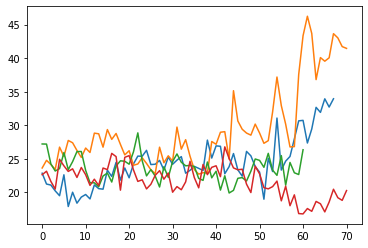

In [43]:
for i in tqdm([5,6,7,8]):#,5,6,7,8]):
    plt.plot(np.max(np.max(np.sqrt(np.asarray(Upol[i]['pol'])[:,0,...]**2+np.asarray(Vpol[i]['pol'])[:,0,...]**2),axis=-1),
                       axis=1))
plt.show()

# Radiation

In [13]:
Xtrain['LW'].shape

(425, 6615000)

In [15]:
import random
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

n_batches=3
n_comps = 140
Xfiles = sorted(glob.glob(f'../../storage/proc/PCA_*.pkl'))
for i in tqdm([1,2]):#range(20)):
    # Choosing 2 random numbers
    #validindices = random.sample([0,1,2,3,4,5,6,7,9], 2)
    valid1 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[1]
    valid2 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[2]
    validindices = [int(valid1),int(valid2)]
    # Separate data
    Xtrain,Xvalid,Xtest = {},{},{}
    Xtrain['LW'],Xvalid['LW'],Xtest['LW'] = preproc.train_valid_test(expvarlist=rthratlw_flat,validindex=validindices,testindex=[8],concat='Yes')
    Xtrain['SW'],Xvalid['SW'],Xtest['SW'] = preproc.train_valid_test(expvarlist=rthratsw_flat,validindex=validindices,testindex=[8],concat='Yes')
    #del rthratlw_flat,rthratsw_flat
    #gc.collect()
    # Train PCA
    PCAdict = {}
    for ivar in tqdm(['LW','SW']):
        inc_pca = IncrementalPCA(n_components=int(Xtrain[ivar].shape[0]/n_batches)-1)#n_comps)
        for X_batch in (np.array_split(Xtrain[ivar],n_batches)):
            inc_pca.partial_fit(X_batch)
        PCAdict[ivar]=inc_pca
    # Save stuff    
    read_and_write.save_to_pickle({'PCA':PCAdict},f'../../storage/proc/PCA_{validindices[0]}_{validindices[1]}.pkl')
    #read_and_write.save_to_pickle({'train':Xtrain,'valid':Xvalid,'test':Xtest},f'../../storage/proc/X_{validindices[0]}_{validindices[1]}.pkl')
    del PCAdict,Xtrain,Xvalid,Xtest
    gc.collect()

100%|█████████████████████████████████████████| 2/2 [1:33:24<00:00, 2802.30s/it]
